# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns


from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier, Pool

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
skf=StratifiedKFold(5, shuffle=True)

# 1. Обработка датасета

In [3]:
train = pd.read_csv('train.csv')

In [4]:
y_train = train['label']

nonempty_columns = train.columns[np.sum(train.isna(), axis=0) < 34000]

numeric_columns = train.columns[1:191]
numeric_columns = numeric_columns & nonempty_columns

categorical_columns = train.columns[191:-1]
categorical_columns = categorical_columns & nonempty_columns

train = train[numeric_columns.append(categorical_columns)]

In [5]:
cat_cols, num_cols = categorical_columns, numeric_columns

# 2. Заполнение средним

In [6]:
mean_numerical_values = train[num_cols].mean()

X_numeric = train[num_cols].fillna(mean_numerical_values)
X_categorical = train[cat_cols].fillna('Not_known')

X_train = pd.concat([X_numeric, X_categorical], axis=1)

## Инструкции

#### 1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [7]:
from sklearn.model_selection import learning_curve

In [8]:
model = CatBoostClassifier(eval_metric='AUC', cat_features=categorical_columns)

In [10]:
res = learning_curve(model, X_train, y_train, n_jobs=-1,
                     cv=StratifiedKFold(5, shuffle=True),
                     train_sizes=np.linspace(0.1, 1, 5),
                     scoring='roc_auc')

In [11]:
x = res[0]
train_scores = res[1]
test_scores = res[2]

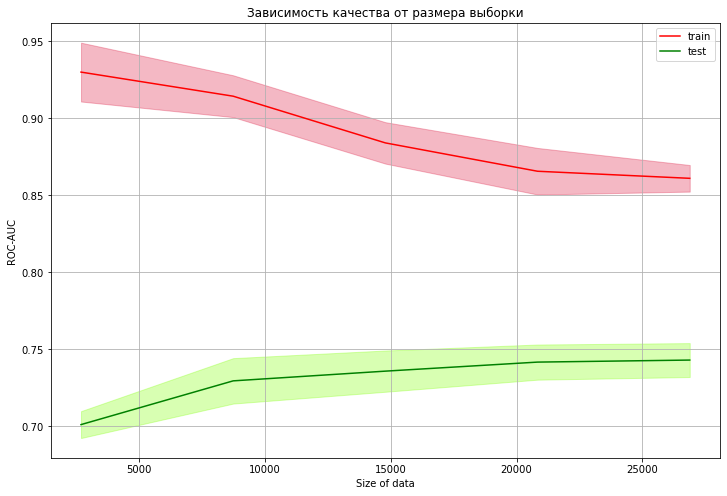

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

axes.grid()
axes.fill_between(x, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                  np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.3, color='crimson')
axes.fill_between(x, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                  np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.3, color='chartreuse')
axes.plot(x, np.mean(train_scores, axis=1), color='red', label='train')
axes.plot(x, np.mean(test_scores, axis=1), color='green', label='test')

axes.set_title('Зависимость качества от размера выборки')
axes.set_xlabel('Size of data')
axes.set_ylabel('ROC-AUC')

axes.legend();

Хоть и кривые сходятся, но score получается лучше при большой выборке.

#### 2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

#### 2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Первой категории у нас и так много, ей придадим вес 1, будем параметризировать вторую категорию.

In [12]:
weights = [1, 2, 5, 10, 12]
results = []

for w in tqdm(weights):
    model = CatBoostClassifier(eval_metric='AUC', cat_features=categorical_columns, class_weights={-1:1, 1:w}, verbose=0)
    res = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')
    results.append([res.mean(), res.std()])

100%|██████████| 5/5 [55:44<00:00, 668.93s/it]


In [13]:
results = np.array(results)

In [14]:
results[:, 0]

array([0.74200368, 0.73654369, 0.73239591, 0.72619579, 0.72851086])

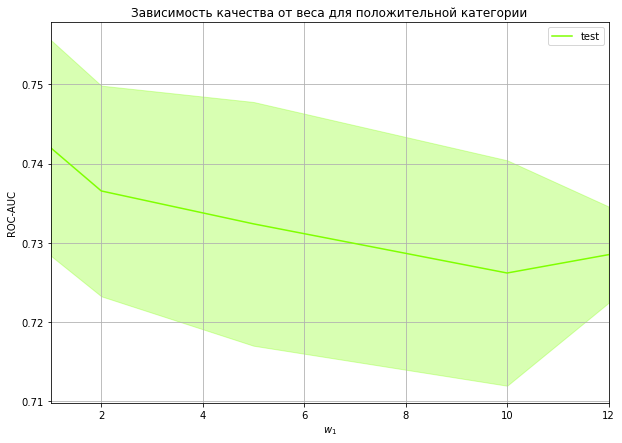

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(10, 7))

axes.set_xlim(1, 12)
axes.grid()

axes.fill_between(weights, results[:, 0] - results[:, 1], results[:, 0] + results[:, 1], alpha=0.3, color='chartreuse')
axes.plot(weights, results[:, 0], color='chartreuse', label='test')

axes.set_title('Зависимость качества от веса для положительной категории')
axes.set_xlabel('$w_1$')
axes.set_ylabel('ROC-AUC')


axes.legend();

Вывод: веса только ухудшают ситуацию.

#### 2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Нам нужна будет выборка с изначальным балансом, чтобы точно померить метрику ROC-AUC

In [16]:
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, stratify=y_train)

neg = y_tr[y_tr == -1].shape[0]

In [17]:
ns = np.linspace(0.2, 1, 10)
results = []

for n in tqdm(ns):
    y_sam = y_tr[y_tr == -1].sample(int(n * neg), random_state=108, replace=False)
    y_sam = pd.concat([y_sam, y_tr[y_tr==1]])
    X_sam = X_tr.loc[y_sam.index]
    
    model = CatBoostClassifier(eval_metric='AUC', cat_features=categorical_columns, verbose=0)
    model.fit(X_sam, y_sam)
    
    pred = model.predict_proba(X_te)
    res = roc_auc_score(y_te, pred[:, 1])
    
    results.append(res)

100%|██████████| 10/10 [14:45<00:00, 88.55s/it] 


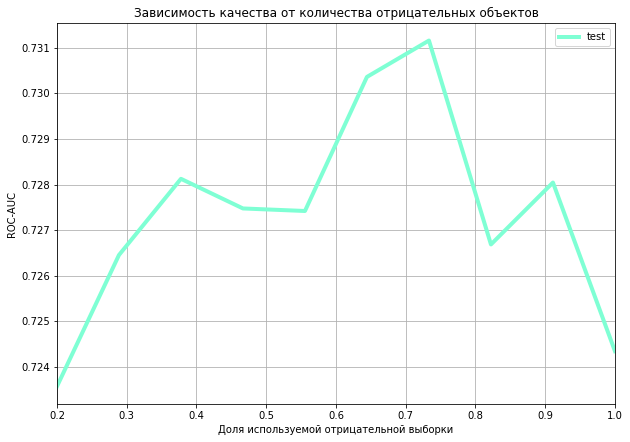

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(10, 7))

axes.set_xlim(0.2, 1)
axes.grid()

axes.plot(ns, results, color='aquamarine', label='test', linewidth=4)

axes.set_title('Зависимость качества от количества отрицательных объектов')
axes.set_xlabel('Доля используемой отрицательной выборки')
axes.set_ylabel('ROC-AUC')


axes.legend();

In [19]:
max(zip(results, ns))[1]

0.7333333333333334

Undersampling с 75% отрицательной выборки может принести интересные результаты. С другой стороны, возможно это всё погрешность. Далее попробуем данный вариант.

#### 3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [20]:
mean_numerical_values = train[num_cols].mean()

X_numeric = train[num_cols].fillna(mean_numerical_values)
X_categorical = train[cat_cols].fillna('Not_known')

X_train = pd.concat([X_numeric, X_categorical], axis=1)

In [21]:
model = CatBoostClassifier(eval_metric='AUC', cat_features=categorical_columns, verbose=0)
res_mean = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')

In [22]:
median_numerical_values = train[num_cols].median()

X_numeric = train[num_cols].fillna(median_numerical_values)
X_categorical = train[cat_cols].fillna('Not_known')

X_train = pd.concat([X_numeric, X_categorical], axis=1)

In [23]:
model = CatBoostClassifier(eval_metric='AUC', cat_features=categorical_columns, verbose=0)
res_median = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')

In [24]:
res = pd.DataFrame([res_mean, res_median]).T
res.columns = ['mean', 'median']

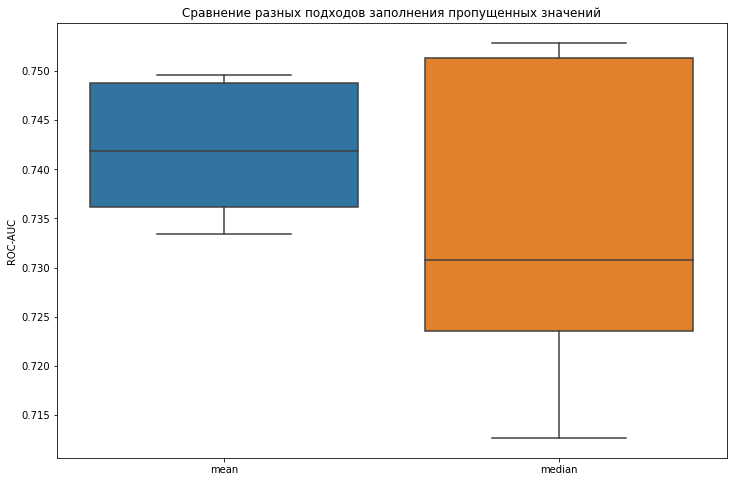

In [25]:
plt.figure(figsize=(12, 8))
cax = sns.boxplot(data=res,)
cax.set_title('Сравнение разных подходов заполнения пропущенных значений')
cax.set_ylabel('ROC-AUC');

В среднем распределение среднего значения выглядит лучше, мало того, это ещё и подтверждается эмпирически во время отправления разных csv.

In [13]:
mean_numerical_values = train[num_cols].mean()

X_numeric = train[num_cols].fillna(mean_numerical_values)
X_categorical = train[cat_cols].fillna('Not_known')

X_train = pd.concat([X_numeric, X_categorical], axis=1)

#### 4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Попробуем к признакам с небольшим количеством категорий применить OneHotEncoder, а к остальным BinaryEncoder. Числовые нормализуем с помощью StanderdScaler.

In [10]:
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

In [11]:
small_columns = cat_cols[X_categorical.nunique()<=18]
big_columns = cat_cols[X_categorical.nunique()>18]

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nc', StandardScaler(), numeric_columns),
        ('sc', OneHotEncoder(handle_unknown="ignore"), small_columns),
        ('bc', BinaryEncoder(handle_unknown="value"), big_columns)
    ])

model = CatBoostClassifier(eval_metric='AUC', verbose=0)

pipe = Pipeline([('prep', preprocessor),
                 ('cb', model)])

In [21]:
res_prep = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='roc_auc')

И рассмотрим нашу стандартную модель (без обработки)

In [23]:
model = CatBoostClassifier(eval_metric='AUC', cat_features=categorical_columns, verbose=0)
res_without_prep = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')

In [21]:
res = pd.DataFrame([res_prep, res_without_prep]).T
res.columns = ['preproc', 'raw']

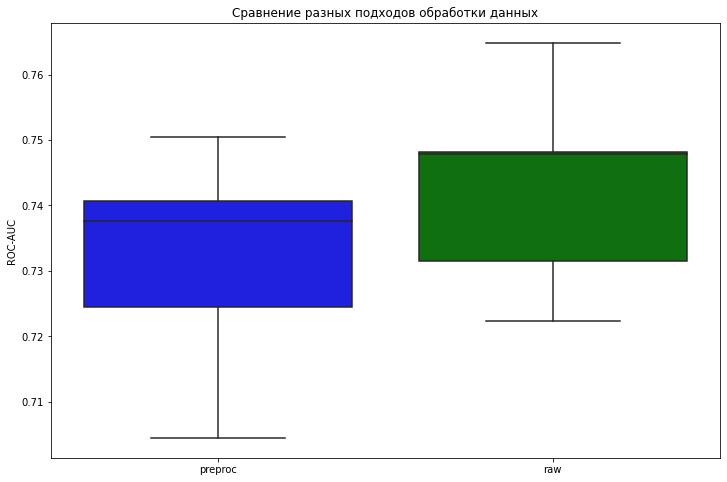

In [22]:
plt.figure(figsize=(12, 8))
cax = sns.boxplot(data=res, palette={'preproc':'blue', 'raw':'green'})
cax.set_title('Сравнение разных подходов обработки данных')
cax.set_ylabel('ROC-AUC');

Не удивительный результат, так как CatBoost хорошо работает без дополнительной обработки, что является огромным плюсом.

#### 5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

l1-regularization

In [7]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [13]:
X_prep = preprocessor.fit_transform(X_train)

In [14]:
l = LinearSVC(penalty='l1', dual=False)
l.fit(X_prep, y_train)
model = SelectFromModel(l, prefit=True)

model = SelectFromModel(l, prefit=True)
X_new = model.transform(X_prep)

In [15]:
print(f"Количество признаков в старом датасете: {X_prep.shape[1]}\nКоличество признаков в новом датасете:  {X_new.shape[1]}")

Количество признаков в старом датасете: 448
Количество признаков в новом датасете:  345


In [16]:
model = CatBoostClassifier(eval_metric='AUC', verbose=0)
res_l1 = cross_val_score(model, X_new, y_train, cv=skf, scoring='roc_auc')

Также используем лес

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

In [18]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_prep, y_train)

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_prep)

In [19]:
model = CatBoostClassifier(eval_metric='AUC', verbose=0)
res_for = cross_val_score(model, X_new, y_train, cv=skf, scoring='roc_auc')

In [24]:
res = pd.DataFrame([res_prep, res_without_prep, res_l1, res_for]).T
res.columns = ['preproc', 'raw', 'l1', 'forest']

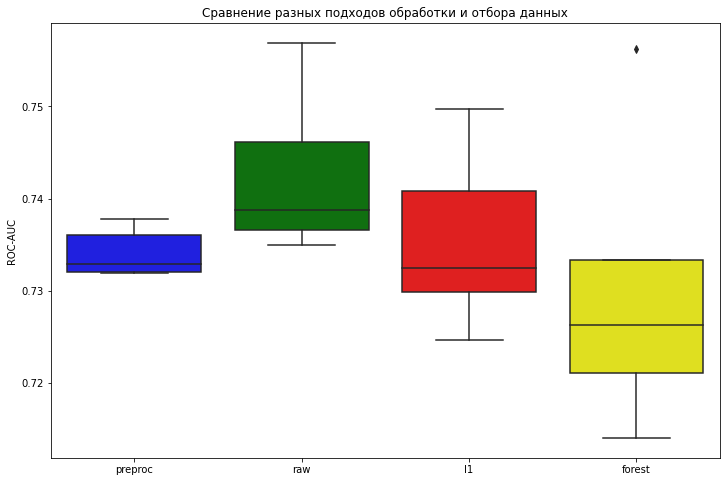

In [25]:
plt.figure(figsize=(12, 8))
cax = sns.boxplot(data=res, palette={'preproc':'blue', 'raw':'green', 'l1':'red', 'forest':'yellow'})
cax.set_title('Сравнение разных подходов обработки и отбора данных')
cax.set_ylabel('ROC-AUC');

l1-регуляризация получилась довольно интересным вариантом, явно лучше, чем просто обработанный вариант. Но всё ещё хуже, чем датасет без обработки.

#### 6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

Есть мнение, что Catboost не требует подбора гиперпараметров. И мы в целом убедились, что чаще всего попытки настроить обучение претерпевали поражение. Также обучение на CatBoost составляет примерно 2-3 минуты, что означает, что каждая кросссвалидация обходится в 10-12 минут. Сама попытка подобрать параметры в таком случае является неэффективной, так как время - тоже ресурс.

#### 7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

Воспользуемся функцией feature_importances из CatBoost.

In [26]:
model = CatBoostClassifier(eval_metric='AUC', cat_features=categorical_columns)
model.fit(X_train, y_train)

Learning rate set to 0.046671
0:	total: 60.4ms	remaining: 1m
1:	total: 265ms	remaining: 2m 11s
2:	total: 395ms	remaining: 2m 11s
3:	total: 587ms	remaining: 2m 26s
4:	total: 750ms	remaining: 2m 29s
5:	total: 861ms	remaining: 2m 22s
6:	total: 958ms	remaining: 2m 15s
7:	total: 1.13s	remaining: 2m 20s
8:	total: 1.27s	remaining: 2m 19s
9:	total: 1.44s	remaining: 2m 23s
10:	total: 1.58s	remaining: 2m 21s
11:	total: 1.62s	remaining: 2m 13s
12:	total: 1.79s	remaining: 2m 16s
13:	total: 1.95s	remaining: 2m 17s
14:	total: 2.12s	remaining: 2m 19s
15:	total: 2.29s	remaining: 2m 20s
16:	total: 2.47s	remaining: 2m 23s
17:	total: 2.61s	remaining: 2m 22s
18:	total: 2.78s	remaining: 2m 23s
19:	total: 2.94s	remaining: 2m 23s
20:	total: 3.13s	remaining: 2m 25s
21:	total: 3.14s	remaining: 2m 19s
22:	total: 3.29s	remaining: 2m 19s
23:	total: 3.45s	remaining: 2m 20s
24:	total: 3.6s	remaining: 2m 20s
25:	total: 3.76s	remaining: 2m 20s
26:	total: 3.91s	remaining: 2m 21s
27:	total: 3.93s	remaining: 2m 16s
28:	

233:	total: 37.5s	remaining: 2m 2s
234:	total: 37.7s	remaining: 2m 2s
235:	total: 37.9s	remaining: 2m 2s
236:	total: 38s	remaining: 2m 2s
237:	total: 38.3s	remaining: 2m 2s
238:	total: 38.5s	remaining: 2m 2s
239:	total: 38.7s	remaining: 2m 2s
240:	total: 38.9s	remaining: 2m 2s
241:	total: 38.9s	remaining: 2m 1s
242:	total: 39.1s	remaining: 2m 1s
243:	total: 39.3s	remaining: 2m 1s
244:	total: 39.5s	remaining: 2m 1s
245:	total: 39.7s	remaining: 2m 1s
246:	total: 39.8s	remaining: 2m 1s
247:	total: 40s	remaining: 2m 1s
248:	total: 40.2s	remaining: 2m 1s
249:	total: 40.3s	remaining: 2m 1s
250:	total: 40.5s	remaining: 2m
251:	total: 40.7s	remaining: 2m
252:	total: 40.9s	remaining: 2m
253:	total: 41.1s	remaining: 2m
254:	total: 41.2s	remaining: 2m
255:	total: 41.4s	remaining: 2m
256:	total: 41.6s	remaining: 2m
257:	total: 41.7s	remaining: 2m
258:	total: 41.9s	remaining: 1m 59s
259:	total: 42.1s	remaining: 1m 59s
260:	total: 42.4s	remaining: 2m
261:	total: 42.6s	remaining: 1m 59s
262:	total: 4

463:	total: 1m 17s	remaining: 1m 29s
464:	total: 1m 17s	remaining: 1m 29s
465:	total: 1m 18s	remaining: 1m 29s
466:	total: 1m 18s	remaining: 1m 29s
467:	total: 1m 18s	remaining: 1m 29s
468:	total: 1m 18s	remaining: 1m 28s
469:	total: 1m 18s	remaining: 1m 28s
470:	total: 1m 18s	remaining: 1m 28s
471:	total: 1m 18s	remaining: 1m 28s
472:	total: 1m 19s	remaining: 1m 28s
473:	total: 1m 19s	remaining: 1m 27s
474:	total: 1m 19s	remaining: 1m 27s
475:	total: 1m 19s	remaining: 1m 27s
476:	total: 1m 19s	remaining: 1m 27s
477:	total: 1m 19s	remaining: 1m 27s
478:	total: 1m 20s	remaining: 1m 27s
479:	total: 1m 20s	remaining: 1m 26s
480:	total: 1m 20s	remaining: 1m 26s
481:	total: 1m 20s	remaining: 1m 26s
482:	total: 1m 20s	remaining: 1m 26s
483:	total: 1m 20s	remaining: 1m 26s
484:	total: 1m 21s	remaining: 1m 26s
485:	total: 1m 21s	remaining: 1m 25s
486:	total: 1m 21s	remaining: 1m 25s
487:	total: 1m 21s	remaining: 1m 25s
488:	total: 1m 21s	remaining: 1m 25s
489:	total: 1m 21s	remaining: 1m 25s
4

690:	total: 1m 55s	remaining: 51.7s
691:	total: 1m 55s	remaining: 51.5s
692:	total: 1m 55s	remaining: 51.3s
693:	total: 1m 56s	remaining: 51.2s
694:	total: 1m 56s	remaining: 51s
695:	total: 1m 56s	remaining: 50.8s
696:	total: 1m 56s	remaining: 50.7s
697:	total: 1m 56s	remaining: 50.5s
698:	total: 1m 56s	remaining: 50.4s
699:	total: 1m 57s	remaining: 50.2s
700:	total: 1m 57s	remaining: 50s
701:	total: 1m 57s	remaining: 49.8s
702:	total: 1m 57s	remaining: 49.7s
703:	total: 1m 57s	remaining: 49.5s
704:	total: 1m 57s	remaining: 49.3s
705:	total: 1m 57s	remaining: 49.1s
706:	total: 1m 58s	remaining: 49s
707:	total: 1m 58s	remaining: 48.8s
708:	total: 1m 58s	remaining: 48.6s
709:	total: 1m 58s	remaining: 48.4s
710:	total: 1m 58s	remaining: 48.3s
711:	total: 1m 58s	remaining: 48.1s
712:	total: 1m 59s	remaining: 47.9s
713:	total: 1m 59s	remaining: 47.8s
714:	total: 1m 59s	remaining: 47.6s
715:	total: 1m 59s	remaining: 47.4s
716:	total: 1m 59s	remaining: 47.3s
717:	total: 1m 59s	remaining: 47.1

923:	total: 2m 33s	remaining: 12.7s
924:	total: 2m 33s	remaining: 12.5s
925:	total: 2m 34s	remaining: 12.3s
926:	total: 2m 34s	remaining: 12.1s
927:	total: 2m 34s	remaining: 12s
928:	total: 2m 34s	remaining: 11.8s
929:	total: 2m 34s	remaining: 11.6s
930:	total: 2m 34s	remaining: 11.5s
931:	total: 2m 35s	remaining: 11.3s
932:	total: 2m 35s	remaining: 11.2s
933:	total: 2m 35s	remaining: 11s
934:	total: 2m 35s	remaining: 10.8s
935:	total: 2m 35s	remaining: 10.7s
936:	total: 2m 35s	remaining: 10.5s
937:	total: 2m 36s	remaining: 10.3s
938:	total: 2m 36s	remaining: 10.2s
939:	total: 2m 36s	remaining: 9.99s
940:	total: 2m 36s	remaining: 9.82s
941:	total: 2m 36s	remaining: 9.66s
942:	total: 2m 37s	remaining: 9.49s
943:	total: 2m 37s	remaining: 9.32s
944:	total: 2m 37s	remaining: 9.16s
945:	total: 2m 37s	remaining: 8.99s
946:	total: 2m 37s	remaining: 8.83s
947:	total: 2m 37s	remaining: 8.66s
948:	total: 2m 38s	remaining: 8.49s
949:	total: 2m 38s	remaining: 8.33s
950:	total: 2m 38s	remaining: 8.

In [27]:
imp_list = list(zip(model.feature_names_, model.feature_importances_))

In [28]:
imp_list.sort(key=lambda x: x[1], reverse=True)

In [29]:
top5 = [i[0] for i in imp_list[:5]]

In [30]:
imp_list.sort(key=lambda x: x[1], reverse=False)

In [31]:
antitop = [i[0] for i in imp_list[:5]]

In [32]:
print('Лучшие пять признаков: ' + ', '.join(top5))

Лучшие пять признаков: Var126, Var189, Var199, Var218, Var113


In [33]:
print('Худшие пять признаков: ' + ', '.join(antitop))

Худшие пять признаков: Var2, Var14, Var26, Var27, Var29


#### 8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [34]:
pred = model.predict_proba(X_train)[:, 1]

In [35]:
errors = np.abs(y_train.apply(lambda x: (x + 1) / 2) - pred)

In [36]:
top10 = errors.sort_values(ascending=False)[:10]
top10

32642    0.991196
8618     0.990680
13800    0.990591
29791    0.988211
9477     0.986958
1088     0.986828
13810    0.986331
26695    0.985837
9040     0.985311
25504    0.983542
Name: label, dtype: float64

In [37]:
error_samples = train.loc[top10.index]
error_samples

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
32642,NaN,NaN,NaN,NaN,NaN,7476.0,28.0,NaN,NaN,NaN,...,4UxGlow,QKW8DRm,catzS2D,M_8D,NaN,ELof,FSa2,ZI9m,NoEd,am7c
8618,NaN,NaN,NaN,NaN,NaN,854.0,14.0,NaN,NaN,NaN,...,4UxGlow,QKW8DRm,catzS2D,LM8l689qOp,NaN,kG3k,Aoh3,ZI9m,ib5G6X1eUxUn6,mj86
13800,NaN,NaN,NaN,NaN,NaN,1246.0,7.0,NaN,NaN,NaN,...,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,ELof,Xa3G,ZI9m,TCU50_Yjmm6GIBZ0lL_,am7c
29791,NaN,NaN,NaN,NaN,NaN,910.0,7.0,NaN,NaN,NaN,...,SpphYOO,d0EEeJi,WADn5d_,NaN,NaN,NaN,rgKb,nIGXDli,F2FyR07IdsN7I,NaN
9477,NaN,NaN,NaN,NaN,NaN,2226.0,7.0,NaN,NaN,NaN,...,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,kG3k,FSa2,ZI9m,ib5G6X1eUxUn6,mj86
1088,NaN,NaN,NaN,NaN,NaN,651.0,7.0,NaN,NaN,NaN,...,uwLfql_,oslk,A5pE4Qn,LM8l689qOp,NaN,ELof,Qcbd,RAYp,55YFVY9,mj86
13810,NaN,NaN,NaN,NaN,NaN,833.0,7.0,NaN,NaN,NaN,...,Qui18fN,oslk,ep2j7qz,LM8l689qOp,NaN,xG3x,5Acm,RAYp,TCU50_Yjmm6GIBZ0lL_,am7c
26695,NaN,NaN,NaN,NaN,NaN,2863.0,7.0,NaN,NaN,NaN,...,UF16siJ,zCkv,APgdzOv,LM8l689qOp,NaN,ELof,szEZ,6fzt,Zy3gnGM,mj86
9040,NaN,NaN,NaN,NaN,NaN,1001.0,7.0,NaN,NaN,NaN,...,2Wb19U9,oslk,SQ6wBif,LM8l689qOp,NaN,NaN,uWr3,RAYp,55YFVY9,am7c
25504,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,ch2oGfM,zCkv,P6pu4Vl,LM8l689qOp,NaN,ELof,TNEC,ZI9m,R4y5gQQWY8OodqDV,mj86


Довольно много нанов в этих объектах, давайте уберём столбцы из нанов

In [38]:
error_samples[error_samples.columns[np.sum(error_samples.isna(), axis=0) < 10]]

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
32642,7476.0,28.0,9136.0,980.0,1225.0,46.0,472.0,166.56,0.0,1792152.0,...,FzaX,4UxGlow,QKW8DRm,catzS2D,M_8D,ELof,FSa2,ZI9m,NoEd,am7c
8618,854.0,14.0,4752.0,200.0,250.0,0.0,40.0,200.00,0.0,92916.0,...,FzaX,4UxGlow,QKW8DRm,catzS2D,LM8l689qOp,kG3k,Aoh3,ZI9m,ib5G6X1eUxUn6,mj86
13800,1246.0,7.0,4712.0,180.0,225.0,4.0,128.0,176.56,0.0,3762.0,...,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,ELof,Xa3G,ZI9m,TCU50_Yjmm6GIBZ0lL_,am7c
29791,910.0,7.0,244.0,152.0,190.0,0.0,40.0,253.52,0.0,3682704.0,...,NaN,SpphYOO,d0EEeJi,WADn5d_,NaN,NaN,rgKb,nIGXDli,F2FyR07IdsN7I,NaN
9477,2226.0,7.0,3908.0,504.0,630.0,14.0,296.0,223.36,0.0,369966.0,...,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,kG3k,FSa2,ZI9m,ib5G6X1eUxUn6,mj86
1088,651.0,7.0,2700.0,164.0,205.0,2.0,40.0,386.64,0.0,1594308.0,...,FzaX,uwLfql_,oslk,A5pE4Qn,LM8l689qOp,ELof,Qcbd,RAYp,55YFVY9,mj86
13810,833.0,7.0,2068.0,124.0,155.0,0.0,0.0,286.96,0.0,10886460.0,...,FzaX,Qui18fN,oslk,ep2j7qz,LM8l689qOp,xG3x,5Acm,RAYp,TCU50_Yjmm6GIBZ0lL_,am7c
26695,2863.0,7.0,3488.0,152.0,190.0,6.0,40.0,235.36,0.0,2695596.0,...,FzaX,UF16siJ,zCkv,APgdzOv,LM8l689qOp,ELof,szEZ,6fzt,Zy3gnGM,mj86
9040,1001.0,7.0,12.0,188.0,235.0,4.0,96.0,292.32,0.0,990942.0,...,FzaX,2Wb19U9,oslk,SQ6wBif,LM8l689qOp,NaN,uWr3,RAYp,55YFVY9,am7c
25504,1533.0,7.0,1384.0,316.0,395.0,14.0,112.0,189.92,0.0,7608360.0,...,FzaX,ch2oGfM,zCkv,P6pu4Vl,LM8l689qOp,ELof,TNEC,ZI9m,R4y5gQQWY8OodqDV,mj86


Довольно сильное сокращение таблицы в несколько раз. То есть значения 130 признаков были предположены нами, когда мы заполняли наны.

Посмотрим на топ-признаки

In [39]:
error_samples[top5]

,Var126,Var189,Var199,Var218,Var113
32642,-20.0,NaN,hOpRIhsUSP,UYBR,-502196.0
8618,-28.0,NaN,CdPgMY1Z52,UYBR,-70255.2
13800,-30.0,NaN,n1zVHpT8NN,cJvF,53568.0
29791,-28.0,NaN,GHfL3MpXAX,cJvF,176128.0
9477,-24.0,NaN,CdPgMY1Z52,UYBR,-1028372.0
1088,-30.0,174.0,DKUDUftgA7,cJvF,-247406.4
13810,-22.0,252.0,P9HTde2,UYBR,132980.8
26695,-20.0,NaN,V4EEkD4AAZ,UYBR,-865692.0
9040,-22.0,342.0,FoJylxy,UYBR,334591.2
25504,-30.0,NaN,3clyC8L,UYBR,144296.0


Мы видим, что у лидирующей шестёрки один из топовых признаков также заполнен нанами.

Вывод: Мы можем работать с нанами и заполнять их, но их влияние может довольно сильно портить всё

#### 9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Возьмём лучшую модель из пункта 6.

In [ ]:
l = LinearSVC(penalty='l1', dual=False, C=2.5)
l.fit(X_prep, y_train)

model_select = SelectFromModel(l, prefit=True)
X_new = pd.DataFrame(model_select.transform(X_prep))

neg = y_train[y_train == -1].shape[0]

y_sam = y_train[y_train == -1].sample(int(0.85 * neg), replace=False)
y_sam = pd.concat([y_sam, y_train[y_train==1]])
X_sam = X_new.loc[y_sam.index]

model = CatBoostClassifier(eval_metric='AUC', verbose=0)
model.fit(X_sam, y_sam)

In [86]:
test = pd.read_csv('orange_small_churn_test_data.csv')
#test = test[nonempty_columns[1:-1]]

In [77]:
X_test_num = test[num_cols].fillna(mean_numerical_values)
X_test_cat = test[cat_cols].fillna('Not_known')

X_test = pd.concat([X_test_num, X_test_cat], axis=1)

X_test_prep = preprocessor.transform(X_test)
X_test_new = pd.DataFrame(model_select.transform(X_test_prep))

In [78]:
y_test = model.predict_proba(X_test_new)[:, 1]

In [87]:
test['result'] = y_test
assignment = test[['ID', 'result']]
assignment.to_csv('best_model.csv', index=False)

In [88]:
assignment

,ID,result
0,0,0.133939
1,1,0.099063
2,2,0.033244
3,3,0.084021
4,4,0.025261
...,...,...
9995,9995,0.024235
9996,9996,0.058060
9997,9997,0.044190
9998,9998,0.039850


Заметного улучшения это не принесло, всё ещё хуже, чем простой кэтбуст на сырых данных.

# Score = 0.70972

#### 10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Наны - плохо. Также нужно отобрать признаки. Но при этом ни в коем случае нельзя обрабатывать категориальные признаки. Именно учёт этих выводов помог мне получить самый лучший результат из всех попыток. Возможно стоит попробовать зашкалировать числовые признаки.